In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!pip3 install transformers 
!pip3 install torch senetencepiece

     |████████████████████████████████| 3.4 MB 8.7 MB/s 
     |████████████████████████████████| 895 kB 27.3 MB/s 
     |████████████████████████████████| 61 kB 683 kB/s 
     |████████████████████████████████| 596 kB 25.8 MB/s 
     |████████████████████████████████| 3.3 MB 47.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: Could not find a version that satisfies the requirement senetencepiece (from versions: none)
ERROR: No matching distribution found for senetencepiece


In [ ]:
from transformers import pipeline

model = pipeline('summarization', max_length=25, min_length=15)

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


Downloading:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

# Creating Training Data

In [ ]:
text_array = []
summary_array = []

text_data = pd.read_excel('/content/cricket_text.xlsx')
text_data.head()

text_array = text_data.to_numpy()

for i in range(0,len(text_array)):
  summary_array.append(model(text_array[i][0])[0]['summary_text'])

In [ ]:
text_array = text_array.ravel()
print(text_array[0])
print(summary_array[0])

The BCCI today announced Team India's 18-member squad for the upcoming Test series against South Africa. Rohit Sharma has been named vice-captain for the series. Hanuma Vihari, who wasn't included in the squad for the Test series against New Zealand, has returned to the squad. The squad also includes Jasprit Bumrah, Shardul Thakur and Mohammad Shami.
 Rohit Sharma has been named vice-captain for the series against South Africa . Hanuma Vihari


In [ ]:
training_data = pd.DataFrame({'text':text_array,'summary':summary_array})
training_data.head()
training_data.to_csv('CricketSummaryData.csv',index=False)

In [ ]:
data = pd.read_csv('/content/CricketSummaryData.csv')
data.shape

(108, 2)

# Determining max sequence length


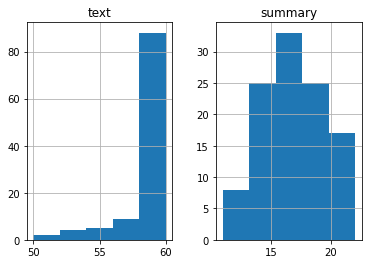

In [ ]:
import matplotlib.pyplot as plt

text_count = []
summary_count = []

for sent in data['text']:
    text_count.append(len(sent.split()))
    
for sent in data['summary']:
    summary_count.append(len(sent.split()))

graph_df = pd.DataFrame() 

graph_df['text'] = text_count
graph_df['summary'] = summary_count

graph_df.hist(bins = 5)
plt.show()

In [ ]:
#max text length
max = 0
for i in data['text']:
  if len(i.split(' '))>max:
    max = len(i.split(' '))
print(max)

60


In [ ]:
#max summary length
max = 0
for i in data['summary']:
  if len(i.split(' '))>max:
    max = len(i.split(' '))
print(max)

23


In [ ]:
# Add sostok and eostok

data['summary'] = data['summary'].apply(lambda x: 'sostok ' + x  + ' eostok')

data.shape

(108, 2)

In [ ]:
# Model to summarize the text between 0-23 words for Summary and 0-60 words for Text
max_text_len = 60
max_summary_len = 24

In [ ]:
# Select the Summaries and Text which fall below max length 

import numpy as np

cleaned_text = np.array(data['text'])
cleaned_summary= np.array(data['summary'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len:
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
data = pd.DataFrame({'text': short_text,'summary': short_summary})

data.shape

(102, 2)

# split train and test data


In [ ]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(data["text"]),
    np.array(data["summary"]),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)

In [ ]:
# Tokenize the text to get the vocab count 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare a tokenizer on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
thresh = 5

cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)

% of rare words in vocabulary:  82.97715549005159


In [ ]:
# Prepare a tokenizer, again -- by not considering the rare words
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

# Convert text sequences to integer sequences 
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 232


In [ ]:
# Prepare a tokenizer on testing data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh = 5

cnt = 0
tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)

# Prepare a tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

# Convert text sequences to integer sequences 
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

# Pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

# Size of vocabulary (+1 for padding token)
y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

% of rare words in vocabulary: 88.24593128390596
Size of vocabulary in Y = 66


In [ ]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []

for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

In [ ]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
latent_dim = 100
embedding_dim = 50

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)  
#embedding class turns positive integers into dense vectors of fixed size
#this layer can be used only as first layer in a model

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4,recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)


# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4,recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.4,recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 60, 50)       11600       ['input_16[0][0]']               
                                                                                                  
 lstm_12 (LSTM)                 [(None, 60, 100),    60400       ['embedding_6[0][0]']            
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                            

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [ ]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=50,
    #callbacks=[es],
    batch_size=128,
    validation_data=([x_val, y_val[:, :-1]],y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]),
    )

Epoch 1/50
1/1 [==============================] - 11s 11s/step - loss: 4.1875 - val_loss: 4.1423
Epoch 2/50
1/1 [==============================] - 1s 647ms/step - loss: 4.1390 - val_loss: 4.0668
Epoch 3/50
1/1 [==============================] - 1s 641ms/step - loss: 4.0586 - val_loss: 3.5569
Epoch 4/50
1/1 [==============================] - 1s 638ms/step - loss: 3.5563 - val_loss: 2.7072
Epoch 5/50
1/1 [==============================] - 1s 624ms/step - loss: 2.6757 - val_loss: 2.3936
Epoch 6/50
1/1 [==============================] - 1s 627ms/step - loss: 2.3252 - val_loss: 2.2479
Epoch 7/50
1/1 [==============================] - 1s 634ms/step - loss: 2.1926 - val_loss: 2.2050
Epoch 8/50
1/1 [==============================] - 1s 635ms/step - loss: 2.1308 - val_loss: 2.1537
Epoch 9/50
1/1 [==============================] - 1s 639ms/step - loss: 2.0992 - val_loss: 2.1769
Epoch 10/50
1/1 [==============================] - 1s 644ms/step - loss: 2.0962 - val_loss: 2.0829
Epoch 11/50
1/1 [===

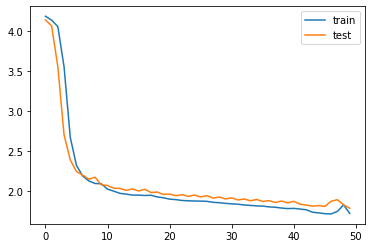

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [ ]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c], [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) \
            >= max_summary_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [ ]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i \
            != target_word_index['eostok']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

In [ ]:

for i in range(0, 10):
    print ('Text:', seq2text(x_tr[i]))
    print ('Original summary:', seq2summary(y_tr[i]))
    print ('Predicted summary:', decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print ('\n')

Text: india wicketkeeper batter took to to new zealand spinner ajaz patel for taking all 10 wickets in a test innings against india in mumbai all of the and he does the in the he was are just well wrote ajaz was in mumbai 
Original summary: ajaz patel for all wickets in test innings against india 
Predicted summary:  sostok sostok sostok the the the in


Text: new zealand batter mitchell praised india opener mayank for the on to bat on stadium in second india england test mayank pressure on it's a ball is definitely there with on it he said mayank played of and 62 in first and second innings respectively 
Original summary: new zealand mitchell praised india for the on to 
Predicted summary:  sostok sostok sostok the the the in


Text: bcci rahul to be the head coach of team india because of the time from home a is about being on the for in a year and he has two said we after he added 
Original summary: to be the of 
Predicted summary:  sostok sostok sostok the the the


Text: talking a

In [ ]:
#print(x_tr[1])

print('text: ', seq2text(x_tr[2]))
print('summary: ', seq2summary(y_tr[2]))
print('prediction: ', decode_sequence(x_tr[2].reshape(1,max_text_len)))

text:  bcci rahul to be the head coach of team india because of the time from home a is about being on the for in a year and he has two said we after he added 
summary:  to be the of 
prediction:   ashes have praised praised kohli ravichandran mitchell second ashes have praised all ashwin india after a was was be be be ashes ashes
